In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import xgboost as xgb

%matplotlib inline

In [2]:
loan_train = pd.read_csv('./data/Train_nyOWmfK_3nIkfd6.csv', index_col='ID')
loan_test = pd.read_csv('./data/Test_bCtAN1w_1.csv', index_col='ID')

In [3]:
%run scripts/helper.py
%run scripts/preprocess.py
%run scripts/models.py
%run scripts/metrics.py
%run scripts/ensembling.py

In [4]:
# columns without any missing values
not_nulls = not_null_cols(loan_train)

In [5]:
# columns with type object that don't have any missing values
obj_cols = cols_with_obj_type(loan_train, not_nulls)

In [6]:
# Dubious applications, removing them
loan_train = loan_train[(loan_train.index != 'ID036559D40')
                        & (loan_train.index != 'ID113457T20')]

In [7]:
loan_train_processed, loan_test_processed = process(loan_train, loan_test, obj_cols)

In [8]:
loan_train_processed.columns

Index([u'Gender', u'City', u'Monthly_Income', u'DOB', u'Lead_Creation_Date', u'Loan_Amount_Applied', u'Loan_Tenure_Applied', u'Existing_EMI', u'Employer_Name', u'Salary_Account', u'Mobile_Verified', u'Var5', u'Var1', u'Loan_Amount_Submitted', u'Loan_Tenure_Submitted', u'Interest_Rate', u'Processing_Fee', u'EMI_Loan_Submitted', u'Filled_Form', u'Device_Type', u'Var2', u'Source', u'Var4', u'LoggedIn', u'Disbursed'], dtype='object')

## Exploratory Data Analysis

In [9]:
cities = loan_train_processed.groupby(['City', 'Disbursed']).size().unstack()

In [10]:
cities.sort(columns=1, ascending=False)

Disbursed,0,1
City,,
Delhi,12257,269
Bengaluru,10645,179
Mumbai,10625,169
Pune,5086,121
Hyderabad,7188,84
Chennai,6849,67
Kolkata,2838,50
Gurgaon,1185,27
Jaipur,1307,24


In [11]:
def to_lower_case(c):
    try:
        if math.isnan(c):
            return c
        else:
            return c.lower()
    except:
        return c
    
loan_train_processed['City'] = loan_train_processed.City.map(to_lower_case)
loan_test_processed['City'] = loan_test_processed.City.map(to_lower_case)

In [12]:
# fill missing values with -1 for City
loan_train_processed.City.fillna('-999', inplace=True)
loan_test_processed.City.fillna('-999', inplace=True)

In [13]:
loan_train_processed['Salary_Account'] = loan_train_processed.Salary_Account.map(to_lower_case)
loan_test_processed['Salary_Account'] = loan_test_processed.Salary_Account.map(to_lower_case)

In [14]:
# fill missing values with -1 for City
loan_train_processed.Salary_Account.fillna('-999', inplace=True)
loan_test_processed.Salary_Account.fillna('-999', inplace=True)

In [15]:
loan_train_processed['Employer_Name'] = loan_train_processed.Employer_Name.map(to_lower_case)
loan_test_processed['Employer_Name'] = loan_test_processed.Employer_Name.map(to_lower_case)

In [16]:
# fill missing values with -1 for Employer's name
loan_train_processed.Employer_Name.fillna('-999', inplace=True)
loan_test_processed.Employer_Name.fillna('-999', inplace=True)

## Data preparation and Cleaning

In [17]:
# encode city names and salary account in train and test
loan_train_processed, loan_test_processed = process(loan_train_processed, loan_test_processed, ['City', 
                                                                                                'Salary_Account',
                                                                                                'Employer_Name'])

In [18]:
# fill missing values for loan_amount_applied and loan_tenure_applied
loan_train_processed.Loan_Amount_Applied.fillna(loan_train_processed.Loan_Amount_Applied.median(), inplace=True)
loan_train_processed.Loan_Tenure_Applied.fillna(loan_train_processed.Loan_Tenure_Applied.median(), inplace=True)

loan_test_processed.Loan_Amount_Applied.fillna(loan_test_processed.Loan_Amount_Applied.median(), inplace=True)
loan_test_processed.Loan_Tenure_Applied.fillna(loan_test_processed.Loan_Tenure_Applied.median(), inplace=True)

In [19]:
# fill missing values for loan_amount_applied and loan_tenure_applied
loan_train_processed.Loan_Amount_Submitted.fillna(loan_train_processed.Loan_Amount_Submitted.median(), inplace=True)
loan_train_processed.Loan_Tenure_Submitted.fillna(loan_train_processed.Loan_Tenure_Submitted.median(), inplace=True)

loan_test_processed.Loan_Amount_Submitted.fillna(loan_test_processed.Loan_Amount_Submitted.median(), inplace=True)
loan_test_processed.Loan_Tenure_Submitted.fillna(loan_test_processed.Loan_Tenure_Submitted.median(), inplace=True)

In [20]:
# normalize the monthly income variable
loan_train_processed['Monthly_Income'] = np.log1p(loan_train_processed.Monthly_Income)
loan_test_processed['Monthly_Income'] = np.log1p(loan_test_processed.Monthly_Income)

In [21]:
# fill missing values for existing emis
loan_train_processed.Existing_EMI.fillna(-999, inplace=True)
loan_test_processed.Existing_EMI.fillna(-999, inplace=True)

In [22]:
# normalize loan applied amount
loan_train_processed['Loan_Amount_Applied'] = np.log1p(loan_train_processed.Loan_Amount_Applied)
loan_test_processed['Loan_Amount_Applied'] = np.log1p(loan_test_processed.Loan_Amount_Applied)

In [23]:
# normalize loan applied amount
loan_train_processed['Loan_Amount_Submitted'] = np.log1p(loan_train_processed.Loan_Amount_Submitted)
loan_test_processed['Loan_Amount_Submitted'] = np.log1p(loan_test_processed.Loan_Amount_Submitted)

In [24]:
# convert both DOB and Lead_Creation_Date to timestamp
loan_train_processed['DOB'] = pd.to_datetime(loan_train_processed.DOB)
loan_test_processed['DOB'] = pd.to_datetime(loan_test_processed.DOB)

loan_train_processed['Lead_Creation_Date'] = pd.to_datetime(loan_train_processed.Lead_Creation_Date)
loan_test_processed['Lead_Creation_Date'] = pd.to_datetime(loan_test_processed.Lead_Creation_Date)

In [25]:
# calculate age delta for training data
loan_train_processed['age_delta'] = (loan_train_processed.Lead_Creation_Date - loan_train_processed.DOB)

In [26]:
# calculate age delta for testing data
loan_test_processed['age_delta'] = (loan_test_processed.Lead_Creation_Date - loan_test_processed.DOB)

In [27]:
loan_train_processed.Interest_Rate.fillna(-999, inplace=True)
loan_test_processed.Interest_Rate.fillna(-999, inplace=True)

In [28]:
# calculate new feature: age of candidate when applying for loan
def get_age_in_years(age):
    seconds = age / (1e9)
    days = seconds / (24. * 60 * 60)
    years = days / 365.
    return int(years)

loan_train_processed['age_when_applied'] = loan_train_processed.age_delta.apply(get_age_in_years)

In [29]:
loan_test_processed['age_when_applied'] = loan_test_processed.age_delta.apply(get_age_in_years)

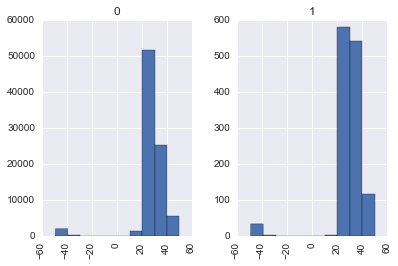

In [30]:
loan_train_processed.hist(column='age_when_applied', by='Disbursed');

### Model Building

In [31]:
features = loan_train_processed[['City', 'Salary_Account', 'Interest_Rate', 'Employer_Name', 'Monthly_Income', 
                                 'Loan_Amount_Applied', 'Loan_Tenure_Applied', 
                                 'Existing_EMI', 'Loan_Amount_Submitted',
                                 'Var1', 'Source', 'Var5', 'age_when_applied',
                                 'Filled_Form']]

In [32]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, n_jobs=-1)
kmeans.fit(features)

features.loc[:, 'labels'] = kmeans.labels_

/Users/abhisheksharma/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = np.nan
/Users/abhisheksharma/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [33]:
from sklearn.cross_validation import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(loan_train.Disbursed, n_iter=3, test_size=0.3, random_state=121)

In [34]:
train_idx, test_idx = next(iter(sss))

In [35]:
Xt = features.iloc[train_idx]
Xv = features.iloc[test_idx]

yt = loan_train.Disbursed.iloc[train_idx]
yv = loan_train.Disbursed.iloc[test_idx]

In [44]:
# Xgboost classifier
dtrain = xgb.DMatrix(Xt, label=yt)
dval = xgb.DMatrix(Xv[:15000], label=yv[:15000])
dtest = xgb.DMatrix(Xv[15000:])

# num_pos_examples
ratio = float(np.sum(yt == 0)) / np.sum(yt==1)
# Parameters
param = {'bst:max_depth':8, 'bst:eta':.01, 'bst:subsample':.7, 'bst:min_child_weight': 2, 
         'bst:colsample_bytree': 0.7,'silent':1, 'bst:scale_pos_weight': ratio, 
         'bst:gamma': 6,'objective':'binary:logistic' }

param['nthread'] = 4
plst = param.items()
plst += [('eval_metric', 'auc')]

# Eval-list to watch performance
evallist  = [(dval,'eval'), (dtrain,'train')]

# Training model
num_round = 1500
bst = xgb.train( plst, dtrain, num_round, evallist )

[0]	eval-auc:0.748442	train-auc:0.741003
[1]	eval-auc:0.759786	train-auc:0.757972
[2]	eval-auc:0.777484	train-auc:0.776839
[3]	eval-auc:0.776705	train-auc:0.776538
[4]	eval-auc:0.777002	train-auc:0.775752
[5]	eval-auc:0.776073	train-auc:0.775182
[6]	eval-auc:0.776353	train-auc:0.775947
[7]	eval-auc:0.776517	train-auc:0.775976
[8]	eval-auc:0.777062	train-auc:0.775634
[9]	eval-auc:0.776524	train-auc:0.775450
[10]	eval-auc:0.777000	train-auc:0.775510
[11]	eval-auc:0.777569	train-auc:0.775635
[12]	eval-auc:0.778866	train-auc:0.778253
[13]	eval-auc:0.779001	train-auc:0.780730
[14]	eval-auc:0.778370	train-auc:0.780602
[15]	eval-auc:0.777982	train-auc:0.779067
[16]	eval-auc:0.779035	train-auc:0.780817
[17]	eval-auc:0.779032	train-auc:0.781290
[18]	eval-auc:0.779011	train-auc:0.781796
[19]	eval-auc:0.779026	train-auc:0.781654
[20]	eval-auc:0.778655	train-auc:0.781576
[21]	eval-auc:0.778523	train-auc:0.781067
[22]	eval-auc:0.791517	train-auc:0.791224
[23]	eval-auc:0.793622	train-auc:0.790753
[2

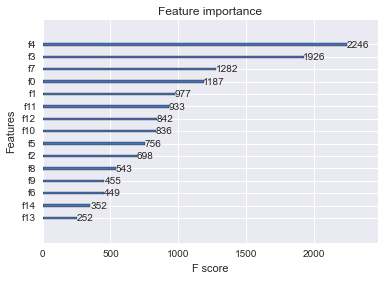

In [37]:
xgb.plot_importance(bst)

In [38]:
yv_pred_xgb = bst.predict(dtest)

In [39]:
print 'ROC AUC score on part of test set %f ' %(score(yv[15000:], yv_pred_xgb))

ROC AUC score on part of test set 0.840533 


In [40]:
# score of xgb on validation set
dv = xgb.DMatrix(Xv)
yv_pred_xgb = bst.predict(dv)

In [41]:
print 'ROC AUC score on test set %f for XGBoost ' %score(yv, yv_pred_xgb)

ROC AUC score on test set 0.851297 for XGBoost 


In [45]:
# Random Forest Classifier
model_rf = random_forest_classifier(Xt, yt)

In [59]:
model_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
yv_pred_rf = predictions(model_rf, Xv)[:, 1]
print 'ROC AUC score on the test set for Random Forest Classifier %f ' %(score(yv, yv_pred_rf))

ROC AUC score on the test set for Random Forest Classifier 0.840751 


In [75]:
# Gradient Boosting Classifier
model_gbc = gradient_boosting_classifier(Xt, yt)

In [98]:
model

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [76]:
yv_pred_gbc = predictions(model_gbc, Xv)[:, 1]
print 'ROC AUC score on the test set for Gradient Boosting Classifier %f ' %(score(yv, yv_pred_gbc))

ROC AUC score on the test set for Gradient Boosting Classifier 0.848172 


## Stacking

In [42]:
yv_stacking = stacked_blending(Xt.values, yt.values, Xv.values)

Creating train and test sets for blending.
0 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Fold 0
[12141 12142 12143 ..., 60909 60910 60911]
Fold 1
[    0     1     2 ..., 60909 60910 60911]
Fold 2
[    0     1     2 ..., 60909 60910 60911]
Fold 3
[    0     1     2 ..., 60909 60910 60911]
Fold 4
[    0     1     2 ..., 49155 49160 49475]
1 GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=5,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=Fal

In [43]:
print 'ROC AUC score after stacking on test set %f ' %(score(yv, yv_stacking))

ROC AUC score after stacking on test set 0.848752 


### Ranked Ensembling

In [117]:
yv_rf_preds_ranked = transform_for_ranked(yv_pred_rf, Xv.index.values)
yv_xgb_preds_ranked = transform_for_ranked(yv_pred_xgb, Xv.index.values)
yv_gbc_preds_ranked = transform_for_ranked(yv_pred_gbc, Xv.index.values)
yv_stacked_ranked = transform_for_ranked(yv_stacking, Xv.index.values)

ranked_ranks = ranked_averaging([yv_stacked_ranked, yv_xgb_preds_ranked])

In [118]:
yv_ensemble_preds = [k3 for k1, k2, k3 in ranked_ranks]

In [119]:
print 'ROC AUC score for ensemble on validation set %f ' %score(yv, yv_ensemble_preds)

ROC AUC score for ensemble on validation set 0.852722 


### Final Model

In [64]:
features_test = loan_test_processed[['City', 'Salary_Account', 'Interest_Rate', 'Employer_Name', 'Monthly_Income', 
                             'Loan_Amount_Applied', 'Loan_Tenure_Applied', 
                             'Existing_EMI', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted',
                             'Var1', 'Source', 'Var5', 'age_when_applied',
                             'Filled_Form', 'Var2']]

In [65]:
features_test.loc[:, 'labels'] = kmeans.predict(features_test)

/Users/abhisheksharma/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = np.nan
/Users/abhisheksharma/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [80]:
# Train Rf and GBR models on full data
model_final_rf = random_forest_classifier(features, loan_train_processed.Disbursed)
model_final_gbr = gradient_boosting_classifier(features, loan_train_processed.Disbursed)

In [103]:
total_data = xgb.DMatrix(features, label=loan_train_processed.Disbursed)
model_final_xgb = xgb.train( plst, total_data, num_round )

In [104]:
total_test_data = xgb.DMatrix(features_test)

In [105]:
final_preds_xgb = model_final_xgb.predict(total_test_data)

In [121]:
final_preds_stacking = stacked_blending(features.values, loan_train_processed.Disbursed.values, features_test.values)

Creating train and test sets for blending.
0 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Fold 0
[16161 16167 16333 ..., 87015 87016 87017]
Fold 1
[    0     1     2 ..., 87015 87016 87017]
Fold 2
[    0     1     2 ..., 87015 87016 87017]
Fold 3
[    0     1     2 ..., 87015 87016 87017]
Fold 4
[    0     1     2 ..., 69680 69681 69682]
1 GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=5,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=Fal

In [81]:
# final_preds_rf = predictions(model_final_rf, features_test)[:, 1]
# final_preds_gbr = predictions(model_final_gbr, features_test)[:, 1]

In [122]:
final_preds_rf_ranks = transform_for_ranked(final_preds_rf, features_test.index.values)
final_preds_xgb_ranks = transform_for_ranked(final_preds_xgb, features_test.index.values)
final_preds_gbc_ranks = transform_for_ranked(final_preds_gbr, features_test.index.values)
final_preds_stacked_ranks = transform_for_ranked(final_preds_stacking, features_test.index.values)

ranked_ranks_final = ranked_averaging([final_preds_xgb_ranks, final_preds_stacked_ranks])

In [123]:
final_preds_ranks = [k3 for k1, k2, k3 in ranked_ranks_final]

In [125]:
create_submission_file(loan_test.index.values, final_preds_stacking, 'stacking_gbr_rf.csv')

## Feature Selection

In [108]:
%run scripts/feature_selection.py

In [109]:
feature_selection(loan_train_processed[['City', 'Salary_Account', 'Employer_Name', 'Monthly_Income','Var5', 
                           'Loan_Amount_Applied', 'Loan_Tenure_Applied', 
                           'Existing_EMI', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted',
                           'Var1', 'Filled_Form', 'Device_Type', 'Var2', 'Source', 'Var5', 'age_when_applied']], 
                  loan_train_processed.Disbursed)

initial f1 score based on extra trees classifier:  0.0
feature importance:  [ 0.09203676  0.08384553  0.11182189  0.11072908  0.04303247  0.05550208
  0.03880343  0.08399025  0.0735262   0.03622075  0.04435319  0.01275061
  0.00250464  0.02240173  0.04466838  0.04152769  0.10228534]
sorted feature importances:  [ 0.11182189  0.11072908  0.10228534  0.09203676  0.08399025  0.08384553
  0.0735262   0.05550208  0.04466838  0.04435319  0.04303247  0.04152769
  0.03880343  0.03622075  0.02240173  0.01275061  0.00250464]
output format:
no of features, f1-score, roc-score of class-predictions, roc-score of probabilities
1 0.00481927710843 0.500686913274 0.564706467202
2 0.00497512437811 0.500939595594 0.809889017203
3 0.00502512562814 0.501017344 0.809101102236
4 0.01 0.502306807422 0.812684448935
5 0.0102301790281 0.502481741336 0.81692275472
6 0.00516795865633 0.501231152117 0.823756982092
7 0.0 0.499727880578 0.826796089947
8 0.0 0.499825066086 0.828271528778
9 0.0 0.49974731768 0.83190295

## Unsupervised Learning

In [39]:
non_disbursed_examples = loan_train_processed[loan_train_processed.Disbursed == 0]

In [40]:
non_disbursed_features = non_disbursed_examples[['City', 'Salary_Account', 'Employer_Name', 'Monthly_Income', 
                           'Loan_Amount_Applied', 'Loan_Tenure_Applied', 
                           'Existing_EMI', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted',
                           'Var1', 'Filled_Form', 'Device_Type', 'Var2', 'Source', 'Var5', 'age_when_applied']]

In [41]:
from sklearn.cluster import KMeans

In [42]:
kmeans = KMeans(n_clusters=4, n_init=10, n_jobs=-1)
kmeans.fit(non_disbursed_features)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=-1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [44]:
labels = kmeans.predict(non_disbursed_features)

In [46]:
non_disbursed_features.loc[:,'labels'] = labels

/Users/abhisheksharma/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = np.nan
/Users/abhisheksharma/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [47]:
non_disbursed_features.columns

Index([u'City', u'Salary_Account', u'Employer_Name', u'Monthly_Income', u'Loan_Amount_Applied', u'Loan_Tenure_Applied', u'Existing_EMI', u'Loan_Amount_Submitted', u'Loan_Tenure_Submitted', u'Var1', u'Filled_Form', u'Device_Type', u'Var2', u'Source', u'Var5', u'age_when_applied', u'labels'], dtype='object')

In [49]:
from collections import Counter

In [50]:
Counter(labels)

Counter({0: 47368, 2: 38377, 1: 1, 3: 1})

In [51]:
non_disbursed_features[(non_disbursed_features['labels'] == 1)|
                       (non_disbursed_features['labels'] == 3)]

,City,Salary_Account,Employer_Name,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Loan_Amount_Submitted,Loan_Tenure_Submitted,Var1,Filled_Form,Device_Type,Var2,Source,Var5,age_when_applied,labels
ID,,,,,,,,,,,,,,,,,
ID036559D40,177,46,301,18.603836,13.122365,0,5454365,13.122365,5,12,0,1,1,24,15,40,1
ID113457T20,462,22,23661,17.341871,13.815512,5,10000000,13.815512,5,8,0,1,6,0,13,45,3


In [60]:
loan_train.ix['ID113457T20']

Gender                                     1
City                                     462
Monthly_Income                      17.34187
DOB                      1970-01-01 00:00:00
Lead_Creation_Date       2015-07-24 00:00:00
Loan_Amount_Applied                 13.81551
Loan_Tenure_Applied                        5
Existing_EMI                           1e+07
Employer_Name                          23661
Salary_Account                            22
Mobile_Verified                            1
Var5                                      13
Var1                                       8
Loan_Amount_Submitted               13.81551
Loan_Tenure_Submitted                      5
Interest_Rate                          13.99
Processing_Fee                          5000
EMI_Loan_Submitted                  23263.07
Filled_Form                                0
Device_Type                                1
Var2                                       6
Source                                     0
Var4      

In [62]:
loan_train_processed.ix['ID036559D40']

Gender                                     1
City                                     177
Monthly_Income                      18.60384
DOB                      1975-03-13 00:00:00
Lead_Creation_Date       2015-05-29 00:00:00
Loan_Amount_Applied                 13.12237
Loan_Tenure_Applied                        0
Existing_EMI                         5454365
Employer_Name                            301
Salary_Account                            46
Mobile_Verified                            1
Var5                                      15
Var1                                      12
Loan_Amount_Submitted               13.12237
Loan_Tenure_Submitted                      5
Interest_Rate                           15.5
Processing_Fee                          5000
EMI_Loan_Submitted                   12026.6
Filled_Form                                0
Device_Type                                1
Var2                                       1
Source                                    24
Var4      

** In both the cases existing EMI is too high, might be the case that this might be not be recorded properly. **

In [81]:
non_disbursed_features_0 = non_disbursed_features[non_disbursed_features['labels'] == 0]
non_disbursed_features_0 = non_disbursed_features_0[non_disbursed_features_0.columns.drop('labels')]

non_disbursed_features_2 = non_disbursed_features[non_disbursed_features['labels'] == 2]
non_disbursed_features_2 = non_disbursed_features_2[non_disbursed_features_2.columns.drop('labels')]

In [82]:
disbursed_examples = loan_train_processed[loan_train_processed.Disbursed == 1]
disbursed_features = disbursed_examples[['City', 'Salary_Account', 'Employer_Name', 'Monthly_Income', 
                           'Loan_Amount_Applied', 'Loan_Tenure_Applied', 
                           'Existing_EMI', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted',
                           'Var1', 'Filled_Form', 'Device_Type', 'Var2', 'Source', 'Var5', 'age_when_applied']]

In [83]:
dataset_0 = np.concatenate((non_disbursed_features_0.values, disbursed_features.values), axis=0)

In [85]:
dataset_2 = np.concatenate((non_disbursed_features_2.values, disbursed_features.values), axis=0)

In [86]:
labels_0 = np.concatenate(([0.] * non_disbursed_features_0.shape[0], [1.] * disbursed_features.shape[0]))

In [89]:
labels_2 = np.concatenate(([0.] * non_disbursed_features_2.shape[0], [1.] * disbursed_features.shape[0]))

In [91]:
from sklearn.cross_validation import train_test_split

In [92]:
dataset_0_train, dataset_0_test, y_0_t, y_0_v = train_test_split(dataset_0, labels_0, 
                                                                 test_size=0.3, random_state=9)

In [93]:
gbr_est = gradient_boosting_classifier(dataset_0_train, y_0_t)

In [95]:
gbr_pred_t = gbr_est.predict_proba(dataset_0_train)[:, 1]
print 'ROC AUC score on training set %f ' %(score(y_0_t, gbr_pred_t))

ROC AUC score on training set 0.940745 


In [96]:
gbr_pred_v = gbr_est.predict_proba(dataset_0_test)[:, 1]
print 'ROC AUC score on test set %f' %(score(y_0_v, gbr_pred_v))

ROC AUC score on test set 0.906247


In [97]:
dataset_2_train, dataset_2_test, y_2_t, y_2_v = train_test_split(dataset_2, labels_2, 
                                                                 test_size=0.3, random_state=9)

In [98]:
gbr_est_2 = gradient_boosting_classifier(dataset_2_train, y_2_t)

In [99]:
gbr_pred_t_2 = gbr_est_2.predict_proba(dataset_2_train)[:, 1]
print 'ROC AUC score on training set %f ' %(score(y_2_t, gbr_pred_t_2))

ROC AUC score on training set 0.952114 


In [100]:
gbr_pred_v_2 = gbr_est_2.predict_proba(dataset_2_test)[:, 1]
print 'ROC AUC score on test set %f' %(score(y_2_v, gbr_pred_v_2))

ROC AUC score on test set 0.920762


In [140]:
first_test_set = dataset_0_test[:6000]
second_test_set = dataset_2_test[:6000]

In [141]:
unseen = np.concatenate((first_test_set, second_test_set), axis=0)

In [142]:
labels_first = y_0_v[:6000]
labels_second = y_2_v[:6000]

unseen_labels = np.hstack((labels_first, labels_second))

In [143]:
unseen_pred_0 = gbr_est.predict_proba(unseen)[:, 1]
unseen_pred_2 = gbr_est_2.predict_proba(unseen)[:, 1]
unseen_ensemble = .5 * unseen_pred_0 + .5 * unseen_pred_2
print 'ROC AUC score on cluster 2 examples %f ' %(score(unseen_labels, unseen_ensemble))

ROC AUC score on cluster 2 examples 0.849828 


In [145]:
# Training on full dataset 
gbr_cluster_0_est = gradient_boosting_classifier(dataset_0, labels_0)
gbr_cluster_2_est = gradient_boosting_classifier(dataset_2, labels_2)

In [152]:
# Predictions
gbr_cluster_0_pred = predictions(gbr_cluster_0_est, features_test)[:, 1]
gbr_cluster_2_pred = predictions(gbr_cluster_2_est, features_test)[:, 1]

In [153]:
gbr_final_preds_ensemble = 0.5 * gbr_cluster_0_pred + 0.5 * gbr_cluster_2_pred

In [154]:
create_submission_file(loan_test.index.values, gbr_final_preds_ensemble, 
                       'ensemble_gbr_clusters.csv')